<a href="https://colab.research.google.com/github/prateekchandrajha/random-computational-finance/blob/main/monte_carlo_risk_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VaR and CVA

Two ways of accounting for risk in financial transactions: Value at Risk
(VaR) and Credit Valuation Adjustment (CVA). The module begins by defining VaR and
discusses how to calculate it using Monte-Carlo Methods. Examples of how to implement
Monte Carlo Methods in Python for VaR simulation are provided. The module concludes by
defining CVA and explaining how it can be calculated using the Black-Scholes model by
Merton.

A technique for quantifying the risk in a portfolio is known as a risk metric. This gives us a way
of numerically describing the amount of uncertainty in that portfolio. Note that we will be
talking about portfolios throughout this unit. A portfolio is just a group of assets.
A few examples of potential risk metrics include volatility (or variance) and
correlation. These give an idea of the extent to which your portfolio's value could
decrease, and how susceptible it is to massive swings in value. However, in order
for them to fully characterize the risk inherent in the portfolio, you would need the distribution
of returns to be multivariate normal, which is very unlikely. Thus, we would need to use a more
general metric: Value at Risk.

## Value at Risk

Value at Risk gives an indication of how much you stand to lose on a portfolio with a given
probability, over a specific time period. This can be measured in absolute terms (we could lose
100 in portfolio value) or in relative terms (the value of our portfolio will decrease by 5%).
Because of the possible usefulness of both measures, we will present both potential definitions
(although they are linked regardless).

For example, suppose we have a portfolio that is worth 100. Say we know that there is a 5%
chance that the portfolio will have a value of 20 or less. Then the 5% VaR for the portfolio is  dollars 80,
or 80%. We are 95% confident that the value of our portfolio will not fall by more than dollars 80. Note that there is a different VaR for different significance levels, and different time periods. It
is very important to note that VaR changes when we change these quantities.


More explicitly, Monte Carlo VaR models work as follows:

• Determine dynamics for the assets in your portfolio.

• Use Monte Carlo simulation to simulate the value of these assets 𝑛-days into the future.

• Determine your portfolio value in each scenario.

• Determine the α-quantile of these projected portfolio values.

In [28]:
import numpy as np
from scipy.stats import norm, uniform
import numpy.matlib
import matplotlib.pyplot as plt
import math
import random 

In [29]:
S0 = np.array([[100],[95],[50]])
sigma = np.array([[0.15],[0.2],[0.3]])
cor_mat = np.array([[1,0.2,0.4],[0.2,1,0.8],[0.4,0.8,1]])

L = np.linalg.cholesky(cor_mat) # cholesky decomposition

r=0.1
T=1

In [30]:
# monte carlo est of VaR

np.random.seed(0)

t_simulations = 1000

alpha = 0.05

portval_current = np.sum(S0)



In [31]:
def terminal_share_price(S_0, risk_free_rate, sigma, Z, T):
  """generates the terminal share price given some random normal values, Z"""
  return S_0*np.exp((risk_free_rate - sigma**2/2)*T + sigma*np.sqrt(T)*Z)



In [32]:
# creating 10000 simulations for future portfolio values

Z = np.matmul(L, norm.rvs(size=[3,t_simulations]))

portval_future = np.sum(terminal_share_price(S0, r, sigma, Z, T), axis=0)



In [33]:
# calculating portfolio returns

portreturn = (portval_future - portval_current)/portval_current

# sorting the returns in order to find the lowest 5%

portreturn = np.sort(portreturn)

# determining VaR

mVaR_estimate = -portreturn[int(np.floor(alpha*t_simulations))-1]

In [34]:
mVaR_estimate

0.14318361044360806

## Historical Simulation to estimate VaR

In [35]:
def share_path(S_0, risk_free_rate, sigma, Z, dT):
  """generates the terminal share price given some random normal values, Z"""
  return S_0*np.exp(np.cumsum((risk_free_rate-sigma**2/2)*dT+sigma*np.sqrt(dT)*Z,1))

This code generates our price path. The price_path variable can be viewed as a
synthetic version of the historical data that we would normally use.


In [36]:
random.seed(0)
t_simulations = 10000
alpha = 0.01
dT = 1/365
sigma = 0.1
S0 = 25
T = 1
mu=0.1
# generating synthetic share price data

# Z = norm.rvs(size=[3,5*365])
# corr_z = np.transpose(np.matmul(L,Z))
# price_path = share_path(S0, r, sigma, corr_z, dT)

# hist_S0 = price_path[-1]
# hist_portval = np.sum(hist_S0)
# hist_portret = [None]*t_simulations

z_histdata = norm.rvs(size = [1,10*365])
price_path = share_path(S0, mu, sigma, z_histdata, dT)

hist_lret = np.log(price_path[0,1:])-np.log(price_path[0,0:-1])
mc_mu = np.mean(hist_lret)*365
mc_sigma = np.std(hist_lret)*np.sqrt(365)

In [37]:
def terminal_shareprice_adj(S_0, mu, sigma, Z, T):
  """generates the terminal share price given some random normal values, Z"""
  return S_0*np.exp((mu)*T + sigma*np.sqrt(T)*Z)

alpha = 0.01
S0 = price_path[0,-1]
mportval_current = S0

mV_estimate = [None]*50
histV_estimate = [None]*50

for i in range(1,51):
  Z = norm.rvs(size = i*1000)
  montportval_future = terminal_shareprice_adj(S0, mc_mu, mc_sigma, Z, T)

  hist_portret = [None]*i*1000

  for j in range(1,i*1000+1):
    rand_samp = uniform.rvs(size=365)*(len(price_path[0])-1)
    rand_samp = [int(x) for x in rand_samp]
    share_returns = hist_lret[rand_samp]
    s_term = S0*np.exp(np.sum(share_returns, axis = 0))
    hist_portret[j-1] = (s_term - mportval_current)/mportval_current

  montport_return = np.sort((montportval_future-mportval_current)/mportval_current)
  hist_portret = np.sort(hist_portret) 

  mV_estimate[i-1] = -montport_return[int(alpha*i*1000)-1]
  histV_estimate[i-1] = -hist_portret[int(np.floor(alpha*i*1000))-1]


In [38]:
S0

60.88709945885182

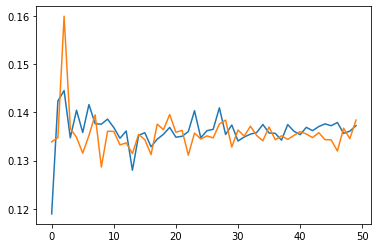

In [39]:
plt.plot(mV_estimate)
plt.plot(histV_estimate)
plt.show()

## Credit Valuation Adjustment

The biggest issue we face with CVA is the difficulty in calculating it, as there are a number of
factors which affect it, such as credit spreads and market factors. As a result, we introduce an
extension to the Black-Scholes model, known as the Merton model.

𝑑𝑉𝑡 = 𝑟𝑉𝑡𝑑𝑡 + σ𝑉𝑡𝑑𝑊𝑡
; 𝑉0 = 𝑉
(3)
where 𝑉𝑡
is the value of the firm at time 𝑡. We assume that the value of the firm is the maximum
amount which they can pay towards settling their debt. For the sake of modeling, we assume
that the total debt which the firm has is some fixed amount, 𝐷, which is due at some future time
𝑇, and that default can only happen at time 𝑇.

Note: Discounted assets are martingales under the risk-neutral
measure.

## Monte Carlo Simulations For Calculating CVA

We are going to be considering the following scenario: you hold a call option on a stock, with an
initial stock value of dollars 100, a volatility of 30%, a strike of dollars 110, and a term of one year. The
continuously-compounded risk-free rate prevalent in the market is 10%. The counterparty to
your call has some probability of default. The firm/counterparty is currently valued at dollars 200, with
a volatility of 25%, and has a debt of dollars 180 which it owes in one year. If the firm were to default,
you would receive 20% of what they owe you – this is their recovery rate.
We are going to be modeling your CVA for a number of different levels of correlation between
the stock on which the option is written and the value of the counterparty. Let's go through the
code that does this.

Here we are capturing the information as per the problem statement. The share is the asset on
which we hold a call option, and the firm is the counterparty for the option.

In [40]:
risk_free = 0.1
S_0 = 100
sigma = 0.3
strike = 100
T=1
V_0 = 200
sigma_firm = 0.25
debt = 180
recovery_rate = 0.2

In [41]:
def terminal_value(S_0, risk_free_rate, sigma, Z, T): # applies to both firm and stock
  """generates the terminal share price given some random normal values, Z"""
  return S_0*np.exp((risk_free_rate - sigma**2/2)*T + sigma*np.sqrt(T)*Z)

def call_payoff(S_T,K):
  return np.maximum(S_T-K,0)

In [42]:
corr_tested = np.linspace(-1,1,21)
cva_estimates = [None]*len(corr_tested)
cva_std = [None]*len(corr_tested)

In [44]:
for i in range(len(corr_tested)):

  correlation = corr_tested[i]

  if (correlation==1 or correlation==-1):
    norm_vec_0 = norm.rvs(size=50000)
    norm_vec_1 = correlation*norm_vec_0
    corr_norm_matrix = np.array([norm_vec_0,norm_vec_1])

  else:
    corr_matrix = np.array([[1,correlation],[correlation,1]])
    norm_matrix = norm.rvs(size = np.array([2,50000]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)

  term_stock_val = terminal_value(S_0, risk_free, sigma, corr_norm_matrix[0,], T)
  call_val = call_payoff(term_stock_val, strike)
  term_firm_val = terminal_value(V_0, risk_free, sigma_firm, corr_norm_matrix[1,], T)
  amount_lost = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_val < debt)*call_val
  cva_estimates[i] = np.mean(amount_lost)
  cva_std[i] = np.std(amount_lost)/np.sqrt(50000)

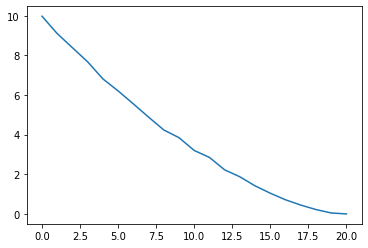

In [46]:
plt.plot(cva_estimates)

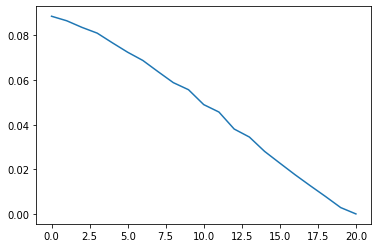

In [47]:
plt.plot(cva_std)

### CVA in real situations:

• CVA is the price one would pay to hedge the portfolio of derivative instruments against counterparty credit risk

• It was introduced in 2007 in order to enhance fair value accounting

• It is largely used in the derivatives markets

• There is not a standardized methodology for CVA as financial companies use different
versions of CVA depending on their needs and complexity required

• Complex CVA approaches require market risk factor simulations and different market
scenarios

• Large financial institutions that have a high share of derivatives in their portfolio invest
heavily in CVA analysis and even have a separate CVA trading desk


In [48]:
import numpy.random as npr
from pylab import *
import matplotlib.pyplot as plt

In [49]:
# Consider the Black-Scholes-Merton model with the following parameters:
S0 = 6.86
r1 = 0.01
sigma1 = 0.2
T1 = 1.
I1 = 400
ST1 = S0 * np.exp((r1 - 0.5 * sigma1 ** 2) * T1 + sigma1 * np.sqrt(T1) * npr.standard_normal(I1))

In [ ]:
# We simulate BlackBerry stock price movements
ST1

In [51]:
L1 = 0.5 # fixed (average) loss level
p1 = 0.01 # probability of default

# Generate default scenarios using Poisson distribution 


Poisson distribution is used in modelling rare events, in our case if the counterparty goes
bankrupt.
Risk-neutral value of the future index level is equal to the current value of the asset today if
there is no default. 

In [54]:
D = npr.poisson(p1 * T1, I1)
D = np.where(D > 1, 1, D)

# Risk-neutral value

np.exp(-r1 * T1) * 1 / I1 * np.sum(ST1)
CVaR1 = np.exp(-r1 * T1) * 1 / I1 * np.sum(L1 * D * ST1)
print(CVaR1)

# Present value of the asset adjusted for the credit risk

S0_CVA1 = np.exp(-r1 * T1) * 1 / I1 * np.sum((1 - L1 * D) * ST1)
print(S0_CVA1)

# Another way for calculating the present value of the asset
S0_adj1 = S0 - CVaR1
print(S0_adj1)

# The number of possible losses
np.count_nonzero(L1 * D * ST1)

0.025065569730647923
6.691609801045676
6.834934430269352


3

In [55]:
D

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

We observe only 4 losses due to credit risk given a number of 400 simulations and 1 % assumed
default probability.